In [1]:
# deep dive on ABC-SMC
# generations 
# projections
# calibration with external models

# Calibration of Epidemic Models to Data with Epydemix - Part 2

In this second part of the tutorial, we will explore more advanced calibration features. Our primary focus will be on the ABC-SMC algorithm, as it is the most flexible and powerful method available. However, many of the concepts and techniques discussed can also be applied to other calibration algorithms.

Let's import the needed packages:

In [2]:
from scipy import stats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from epydemix.model import EpiModel, simulate
from epydemix.visualization import plot_posterior_distribution
from epydemix.calibration import calibrate, rmse
from epydemix.utils import compute_simulation_dates

import seaborn as sns   
colors = sns.color_palette("Dark2")

Before starting we import data and define the model that we used in part 1 of the tutorial:

In [3]:
# import data and divide data into calibration and projection periods
data = pd.read_csv('./data/incidence_data.csv')
data["date"] = pd.to_datetime(data["date"])
data_calibration = data.iloc[:-40]
data_projection = data.iloc[-40:]

# model 
model = EpiModel(predefined_model='SIR')
model.import_epydemix_population(population_name="Indonesia")

# initial conditions (we assume fully S population except for 0.05% infected individual across age groups)
initial_conditions = {"Susceptible": model.population.Nk - (model.population.Nk * 0.05 / 100).astype(int), 
                      "Infected": (model.population.Nk * 0.05/100).astype(int),
                      "Recovered": np.zeros(len(model.population.Nk))}

# simulation dates 
simulation_dates_calibration = compute_simulation_dates(start_date=data_calibration.date.values[0], 
                                                        end_date=data_calibration.date.values[-1])
simulation_dates_projection = compute_simulation_dates(start_date=data_calibration.date.values[0], 
                                                        end_date=data_projection.date.values[-1])

# simulation parameters
parameters = {"initial_conditions_dict": initial_conditions,
              "epimodel": model, 
              "start_date": data_calibration.date.values[0],
              "end_date": data_calibration.date.values[-1]}

# priors
priors = {"transmission_rate": stats.uniform(0.010, 0.020), 
          "recovery_rate": stats.uniform(0.15, 0.1)}

# wrapper function
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    return {"data": results.transitions["Susceptible_to_Infected_total"]}

## 1. ABC-SMC Perturbation Kernels

An important aspect of the ABC-SMC algorithm are pertubation kernels. Perturbation kernels in ABC-SMC are probability distributions used to introduce small random variations to parameter values during the iterative sampling process, allowing the algorithm to explore the parameter space more effectively while maintaining diversity in the population of particles.

By default, in Epydemix, continuous parameters use multivariate normal transition kernels, with the covariance matrix estimated from the previous generation of particles. Discrete parameters, on the other hand, utilize a discrete jump transition kernels.

Users can define their own custom perturbation kernels by implementing the abstract class `Perturbation`. Below, we provide a simple example where we create a perturbation kernel that modifies parameters by adding random noise sampled from a uniform distribution within a specified range:

In [4]:
from epydemix.utils import Perturbation

class ScaledPerturbation(Perturbation):
    def __init__(self, param_name, scale=0.1):
        super().__init__(param_name)
        self.scale = scale

    def propose(self, x):
        """Propose a new value by adding scaled noise (with positive constraint)."""
        return np.abs(x + np.random.uniform(-self.scale, self.scale))

    def pdf(self, x, center):
        """Evaluate the PDF of the kernel."""
        if abs(x - center) <= self.scale:
            return 1 / (2 * self.scale)  # Uniform density within the range
        return 0

    def update(self, particles, weights, param_names):
        """No updates needed for this simple kernel."""
        pass


This user-defined perturbation kernel can then be used in the ABC-SMC algorithm by specifying to which parameter must be applied:

In [5]:
results_abc_smc = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters, 
                    observed_data={"data": data_calibration["data"].values}, 
                    num_particles=100, 
                    max_generations=5, 
                    distance_function=rmse, 
                    perturbations={
                        "transmission_rate": ScaledPerturbation("transmission_rate", scale=0.005)
                    })

Running generation 1, epsilon: 2471400.223530534
	Elapsed time: 00:00:05
Running generation 2, epsilon: 1561768.2663298892
	Elapsed time: 00:00:06
Running generation 3, epsilon: 1016408.2065883656
	Elapsed time: 00:00:06
Running generation 4, epsilon: 638097.2700711987
	Elapsed time: 00:00:19
Running generation 5, epsilon: 496846.9062521041
	Elapsed time: 00:00:23


<Axes: title={'center': 'Transmission rate'}, xlabel='transmission_rate', ylabel='Density'>

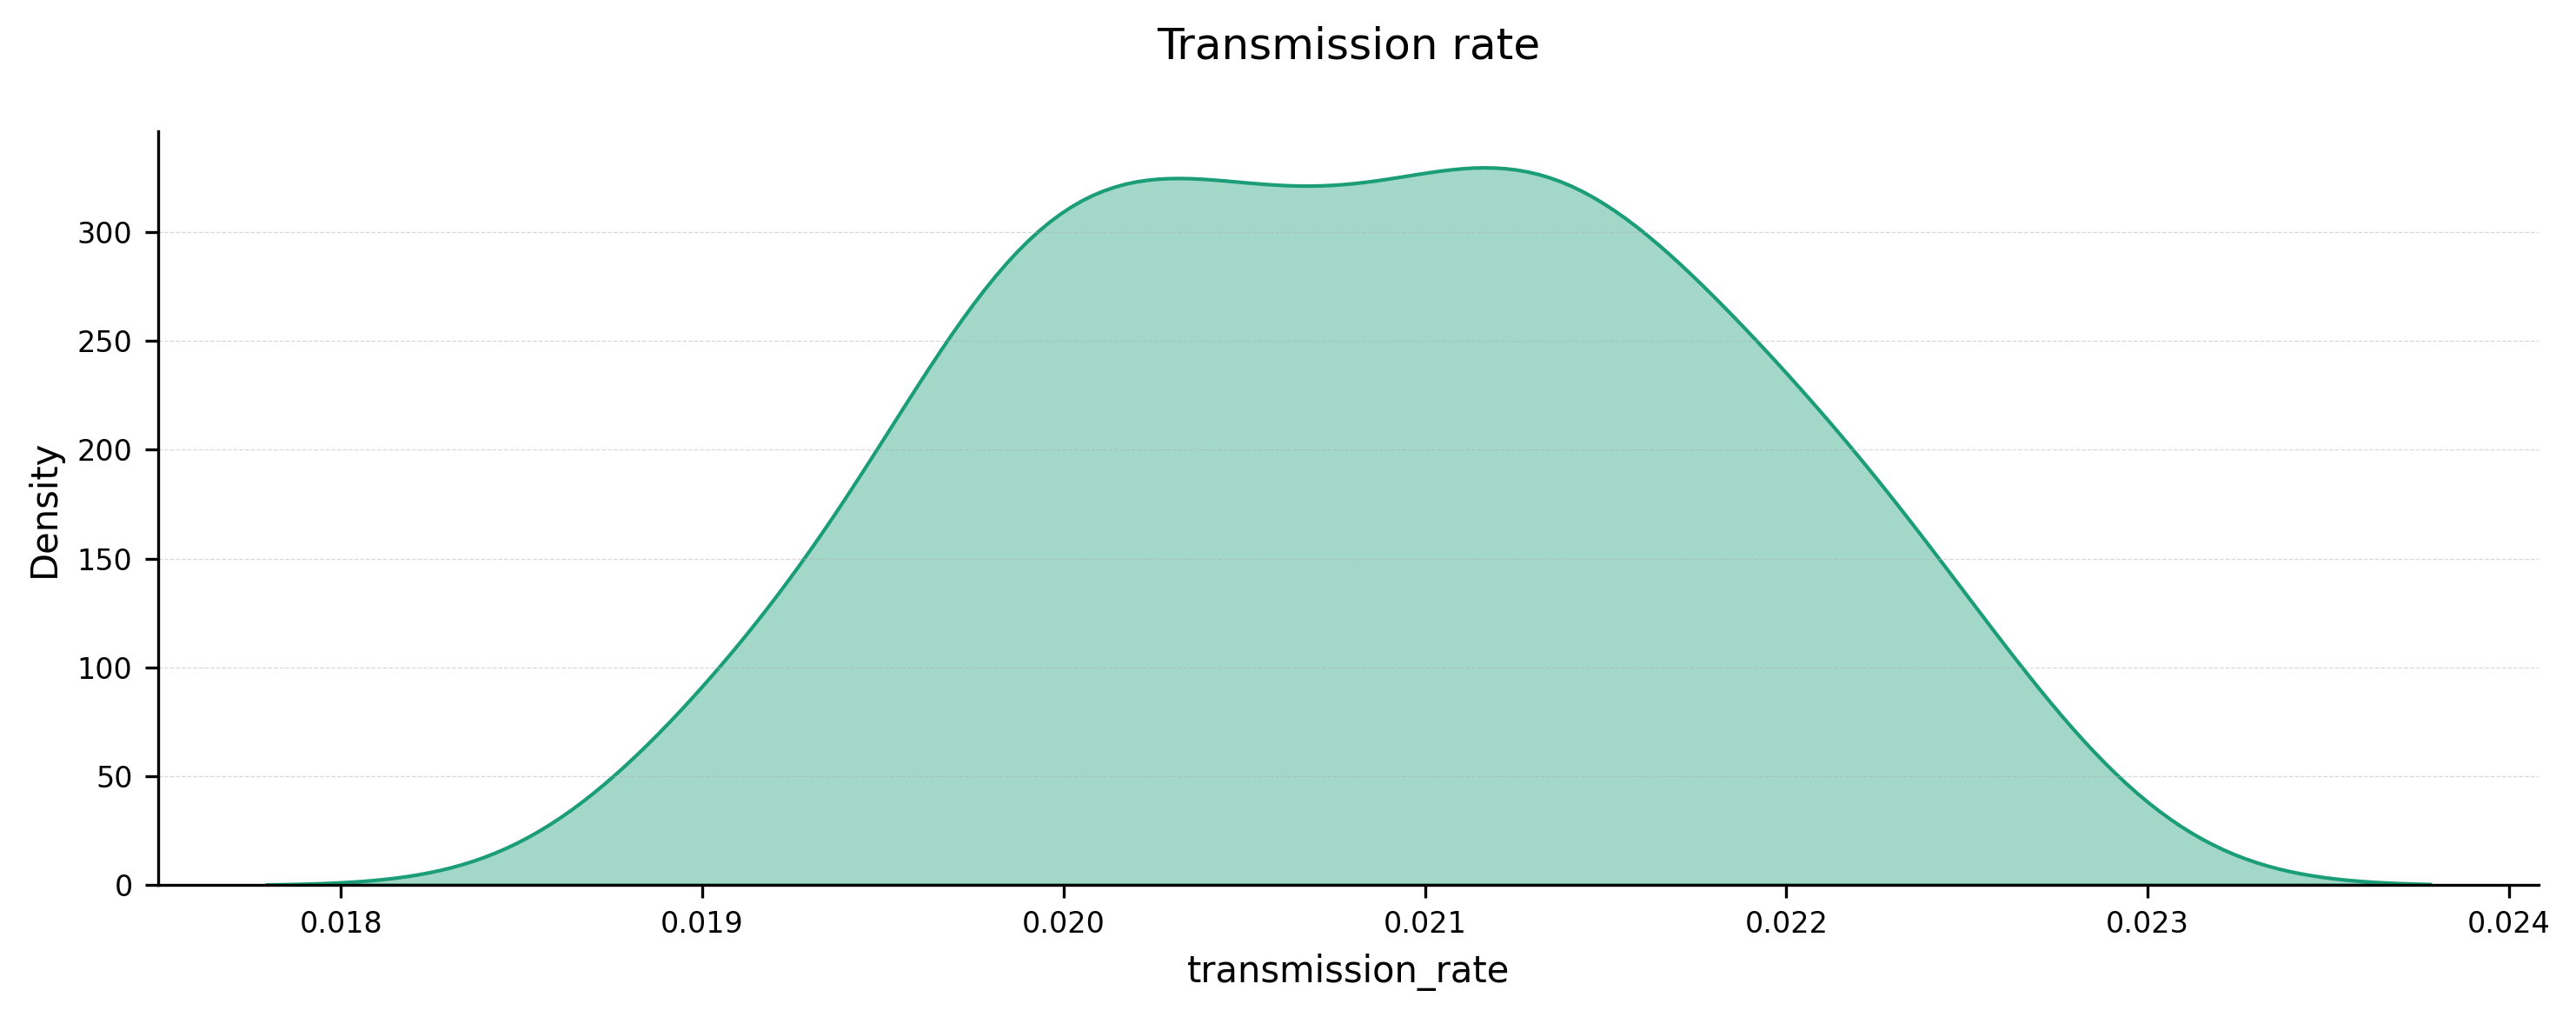

In [6]:
plot_posterior_distribution(results_abc_smc.get_posterior_distribution(), "transmission_rate", kind="kde", title="Transmission rate", color=colors[0], label="ABC-SMC")

We can also test the evolution of the posterior distributions in different generations: 

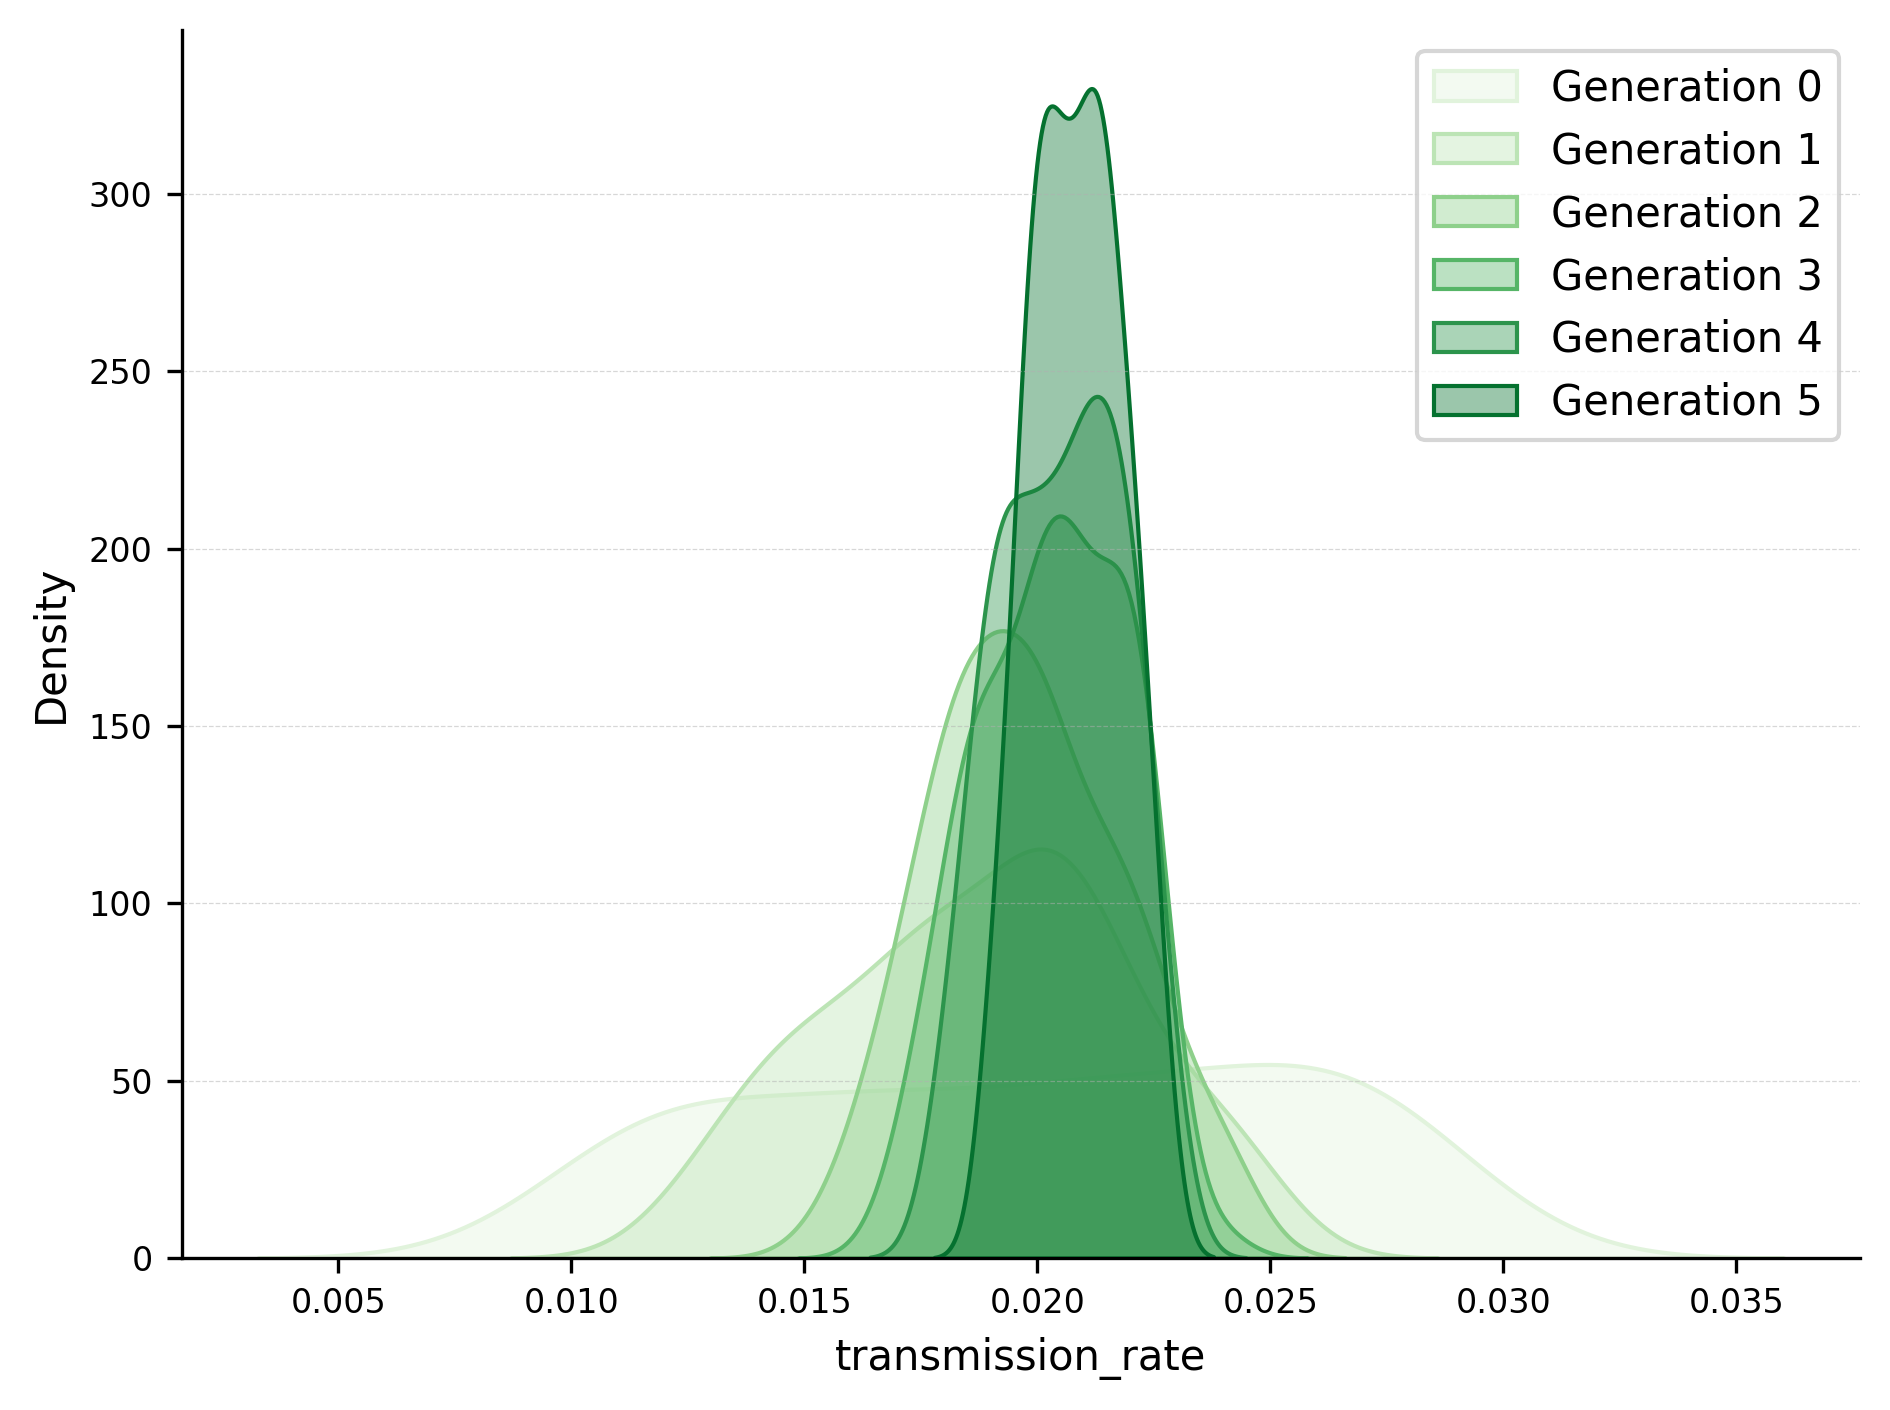

In [7]:
fig, ax = plt.subplots(dpi=300)
for generation, color in zip(range(6), sns.color_palette("Greens", n_colors=6)): 
    plot_posterior_distribution(results_abc_smc.get_posterior_distribution(generation=generation), 
                                parameter="transmission_rate", ax=ax, kind="kde", color=color, label="Generation %d" % generation)
ax.legend() 

## 2. Running Projections

After calibrating the models, it is often useful to run projections into the future to explore how the epidemic might evolve. In **Epydemix**, this can be achieved using the `run_projections` method of the `CalibrationResults` object.

In this tutorial, we previously performed the calibration over a shorter time frame to fit the model to the observed data. Once calibrated, we will use the `run_projections` method of the `CalibrationResults` object to project the epidemic's trajectory over the remaining period, providing insights into possible future outcomes.

In [8]:
# create projection parameters
projection_parameters = parameters.copy()
projection_parameters["end_date"] = data_projection.date.values[-1]

# run projections
results_abc_smc.run_projections(simulate_wrapper, projection_parameters)

We finally plot the results, in terms of median and 90% confidence intervals of number of infected over time during both the calibration and projection phase:

<Axes: >

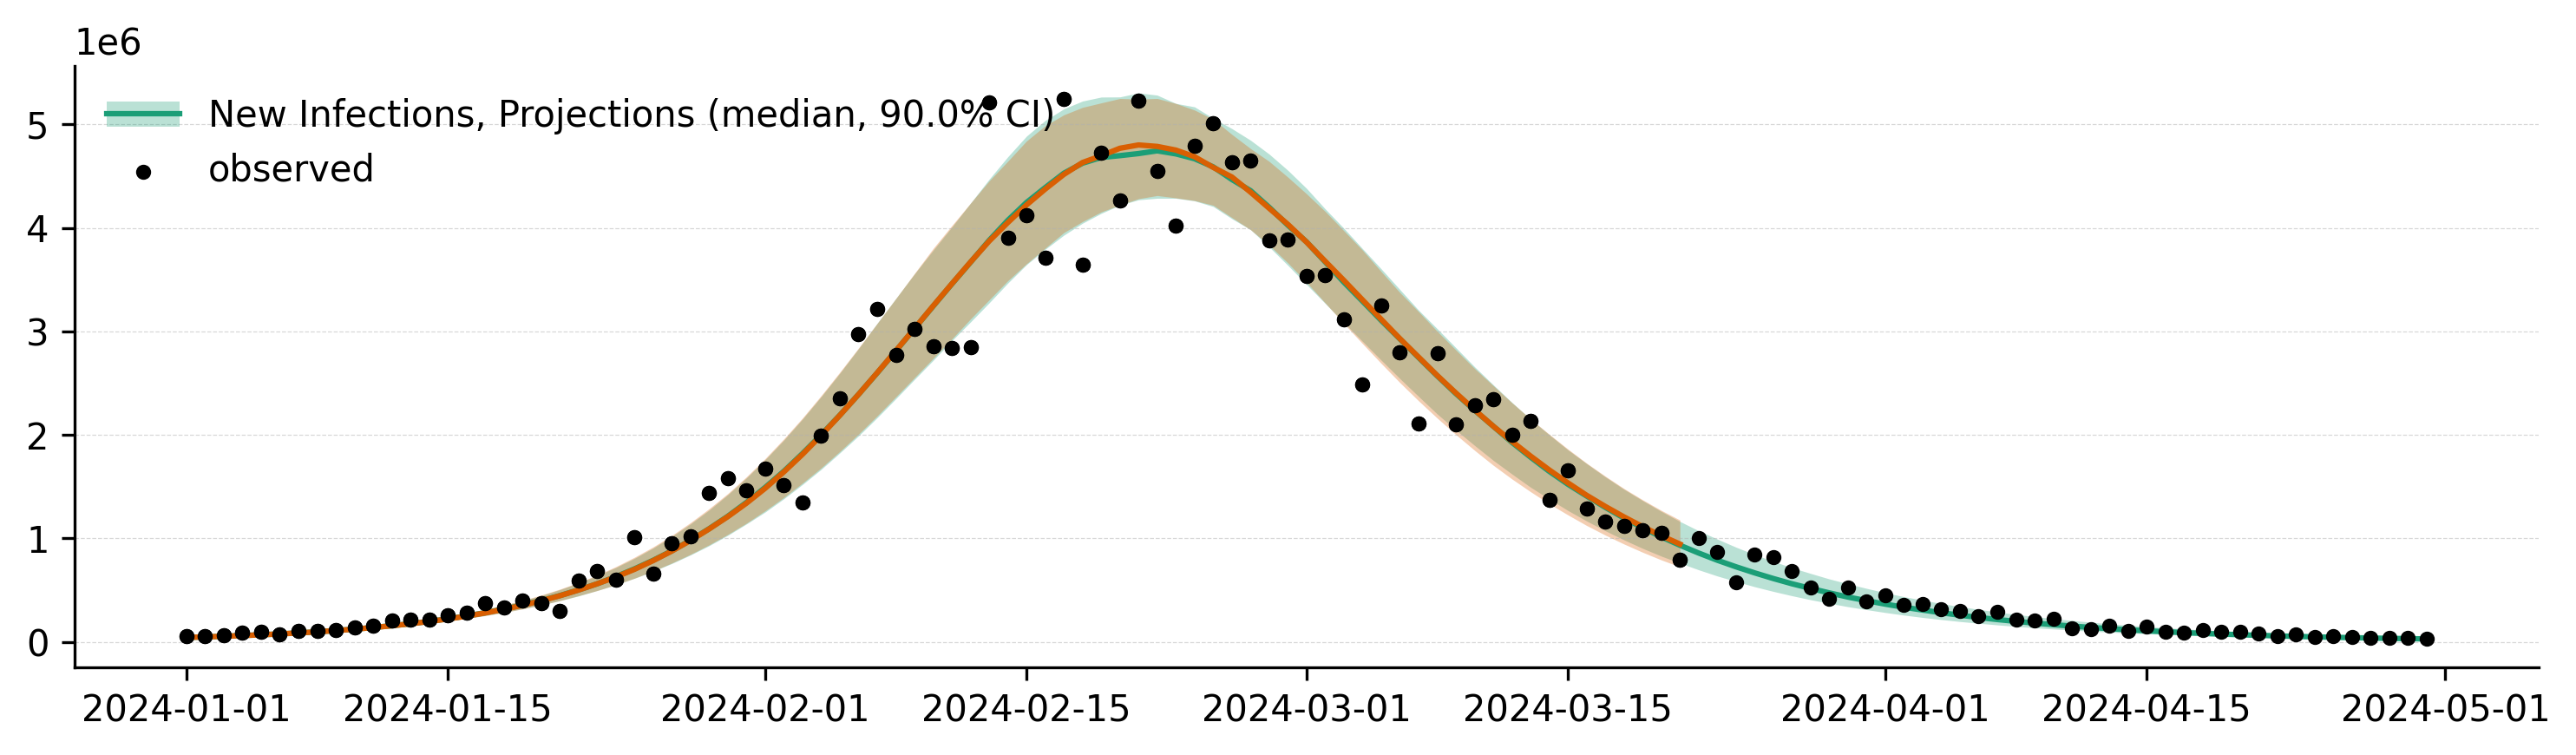

In [14]:
from epydemix.visualization import plot_quantiles

# plot the projections
df_quantiles_calibration = results_abc_smc.get_calibration_quantiles(simulation_dates_calibration)
df_quantiles_projections = results_abc_smc.get_projection_quantiles(simulation_dates_projection)

fig, ax = plt.subplots(dpi=300, figsize=(10, 3))
plot_quantiles(df_quantiles_projections, columns="data", data=data, ax=ax, colors=colors[0], show_legend=True, show_data=True, labels=["New Infections, Projections"])
plot_quantiles(df_quantiles_calibration, columns="data", data=data_calibration, ax=ax, colors=colors[1], show_legend=False, show_data=True)

## 3. Calibration of External Models